<a href="https://colab.research.google.com/github/ArwaAlbassam/Project2_T5/blob/main/Project2_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting car price using linear regression**

# **Import packages**

In [ ]:
from bs4 import BeautifulSoup as bs
import requests
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import (scale, StandardScaler)
from sklearn import linear_model
from sklearn.linear_model import (LinearRegression, Lasso)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
import matplotlib.ticker as plticker
import scipy.stats as stats
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.metrics import (mean_squared_error, r2_score)
import sklearn.metrics as metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data scraping**

Scraping data from cars.com website

In [ ]:
session=requests.session()
headers={"User-Agent":"Mozilla/5.0 (X11; Linux x86_64; rv:60.0) Gecko/20100101 Firefox/60.0","Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8"}
url = 'https://www.cars.com/shopping/results/?makes[]=honda&page=1&page_size=100&stock_type=used&zip=60606'
req=requests.get(url)
soup=bs(req.text,'html.parser')
url2 = 'https://www.cars.com/shopping/results/?makes[]=honda&page=2&page_size=100&stock_type=used&zip=60606'
req2=requests.get(url2)
soup2=bs(req2.text,'html.parser')

# **Exploratory data analysis (EDA)**

 **Pre-Processing**

In [ ]:
DESCRIPTION = []
for element in soup.find_all('a',class_='vehicle-card-link'):
    DESCRIPTION.append(element.text.replace('\n','').split(' ',1))
for element in soup2.find_all('a',class_='vehicle-card-link'):
    DESCRIPTION.append(element.text.replace('\n','').split(' ',1))

len(DESCRIPTION)

200

In [ ]:
len(DESCRIPTION)

200

In [ ]:
DEALER = []
for element in soup.find_all('div',class_='dealer-name'):
    DEALER.append(element.text.replace('\n',''))
for element in soup2.find_all('div',class_='dealer-name'):
    DEALER.append(element.text.replace('\n',''))

In [ ]:
len(DEALER)

200

In [ ]:
MILES_DRIVEN = []
for element in soup.find_all('div',class_='mileage'):
    MILES_DRIVEN.append(element.text.replace('\n','').replace(',','').replace('mi.','').strip())
for element in soup2.find_all('div',class_='mileage'):
    MILES_DRIVEN.append(element.text.replace('\n','').replace(',','').replace('mi.','').strip())
MILES_DRIVEN = list(map(float,MILES_DRIVEN))

In [ ]:
len(MILES_DRIVEN)

200

In [ ]:
type(MILES_DRIVEN[0])

float

In [ ]:
RATE = []
for element in soup.find_all('span',class_='sds-rating__count'):
    RATE.append(element.text.replace('\n',''))
for element in soup2.find_all('span',class_='sds-rating__count'):
    RATE.append(element.text.replace('\n',''))
RATE = list(map(float,RATE))

In [ ]:
len(RATE)

200

In [ ]:
type(RATE[0])

float

In [ ]:
NO_OF_REVIEWS = []
for element in soup.find_all('span',class_='sds-rating__link sds-button-link'):
    NO_OF_REVIEWS.append(element.text.replace('\n','').replace('(','').replace(')','').replace('reviews','').replace('review','').replace(',','').strip())
for element in soup2.find_all('span',class_='sds-rating__link sds-button-link'):
    NO_OF_REVIEWS.append(element.text.replace('\n','').replace('(','').replace(')','').replace('reviews','').replace('review','').replace(',','').strip())
NO_OF_REVIEWS = list(map(int,NO_OF_REVIEWS))

In [ ]:
len(NO_OF_REVIEWS)

200

In [ ]:
type(NO_OF_REVIEWS[0])

int

In [ ]:
PRICE = []
for element in soup.find_all('span',class_='primary-price'):
    PRICE.append(element.text.replace('\n','').replace(',','').replace('$',''))
for element in soup2.find_all('span',class_='primary-price'):
    PRICE.append(element.text.replace('\n','').replace(',','').replace('$',''))
PRICE = list(map(float,PRICE))

In [ ]:
len(PRICE)

200

In [ ]:
type(PRICE[0])

float

In [ ]:
list_of_tuples = list(zip(DESCRIPTION, DEALER, MILES_DRIVEN ,RATE ,NO_OF_REVIEWS, PRICE))

In [ ]:
df = pd.DataFrame(list_of_tuples, columns = ['DESCRIPTION', 'DEALER', 'MILES_DRIVEN', 'RATE','NO_OF_REVIEWS','PRICE'])

In [ ]:
df[['MODEL','CAR_NAME']]=pd.DataFrame(df.DESCRIPTION.tolist(), index= df.index)  

In [ ]:
df

,DESCRIPTION,DEALER,MILES_DRIVEN,RATE,NO_OF_REVIEWS,PRICE,MODEL,CAR_NAME
0,"[2016, Honda CR-V EX]",Honda of Downtown Chicago,46994.0,4.0,67,22665.0,2016,Honda CR-V EX
1,"[2016, Honda Civic LX]",Honda of Downtown Chicago,49473.0,4.0,67,17137.0,2016,Honda Civic LX
2,"[2018, Honda CR-V EX]",Honda of Downtown Chicago,19944.0,4.0,67,28000.0,2018,Honda CR-V EX
3,"[2018, Honda Odyssey EX-L]",Honda City Chicago,37295.0,4.3,635,33599.0,2018,Honda Odyssey EX-L
4,"[2021, Honda Odyssey EX]",Honda City Chicago,3697.0,4.3,635,35999.0,2021,Honda Odyssey EX
...,...,...,...,...,...,...,...,...
195,"[2014, Honda Accord EX-L]",Hyundai of Palatine,31555.0,3.7,43,17500.0,2014,Honda Accord EX-L
196,"[2019, Honda Pilot Touring 7-Passenger]",Advantage Acura of Naperville,38039.0,3.8,20,36439.0,2019,Honda Pilot Touring 7-Passenger
197,"[2017, Honda Accord LX]",Advantage Acura of Naperville,82815.0,3.8,20,17900.0,2017,Honda Accord LX
198,"[2019, Honda Civic LX]",Audi Naperville,28090.0,4.7,126,20557.0,2019,Honda Civic LX


In [ ]:
df = df.iloc[:, [0,7,6,1,2,3,4,5]] # change order of data frame columns 

In [ ]:
df.drop('DESCRIPTION',axis='columns', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df

,CAR_NAME,MODEL,DEALER,MILES_DRIVEN,RATE,NO_OF_REVIEWS,PRICE
0,Honda CR-V EX,2016,Honda of Downtown Chicago,46994.0,4.0,67,22665.0
1,Honda Civic LX,2016,Honda of Downtown Chicago,49473.0,4.0,67,17137.0
2,Honda CR-V EX,2018,Honda of Downtown Chicago,19944.0,4.0,67,28000.0
3,Honda Odyssey EX-L,2018,Honda City Chicago,37295.0,4.3,635,33599.0
4,Honda Odyssey EX,2021,Honda City Chicago,3697.0,4.3,635,35999.0
...,...,...,...,...,...,...,...
195,Honda Accord EX-L,2014,Hyundai of Palatine,31555.0,3.7,43,17500.0
196,Honda Pilot Touring 7-Passenger,2019,Advantage Acura of Naperville,38039.0,3.8,20,36439.0
197,Honda Accord LX,2017,Advantage Acura of Naperville,82815.0,3.8,20,17900.0
198,Honda Civic LX,2019,Audi Naperville,28090.0,4.7,126,20557.0


In [ ]:
df.describe()

,MILES_DRIVEN,RATE,NO_OF_REVIEWS,PRICE
count,200.000000,200.00000,200.000000,200.000000
mean,42309.540000,4.35300,883.870000,25887.075000
std,28158.741629,0.57274,1211.290422,7875.915032
min,2565.000000,2.60000,1.000000,4899.000000
25%,21886.000000,4.07500,72.500000,20705.500000
50%,34667.000000,4.60000,385.000000,25650.000000
75%,51846.500000,4.70000,1094.000000,32587.500000
max,144811.000000,5.00000,7958.000000,43535.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CAR_NAME       200 non-null    object 
 1   MODEL          200 non-null    object 
 2   DEALER         200 non-null    object 
 3   MILES_DRIVEN   200 non-null    float64
 4   RATE           200 non-null    float64
 5   NO_OF_REVIEWS  200 non-null    int64  
 6   PRICE          200 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 11.1+ KB


Missing values:

In [ ]:
df.isnull().sum()

CAR_NAME         0
MODEL            0
DEALER           0
MILES_DRIVEN     0
RATE             0
NO_OF_REVIEWS    0
PRICE            0
dtype: int64

Duplicate:

In [ ]:
df.duplicated().sum()

0

Convert the DataType of the MODEL from object into numeric

In [ ]:
df["MODEL"] = pd.to_numeric(df["MODEL"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Verify the process of converting the data type of the MODEL column

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CAR_NAME       200 non-null    object 
 1   MODEL          200 non-null    int64  
 2   DEALER         200 non-null    object 
 3   MILES_DRIVEN   200 non-null    float64
 4   RATE           200 non-null    float64
 5   NO_OF_REVIEWS  200 non-null    int64  
 6   PRICE          200 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 11.1+ KB


In [ ]:
df 

,CAR_NAME,MODEL,DEALER,MILES_DRIVEN,RATE,NO_OF_REVIEWS,PRICE
0,Honda CR-V EX,2016,Honda of Downtown Chicago,46994.0,4.0,67,22665.0
1,Honda Civic LX,2016,Honda of Downtown Chicago,49473.0,4.0,67,17137.0
2,Honda CR-V EX,2018,Honda of Downtown Chicago,19944.0,4.0,67,28000.0
3,Honda Odyssey EX-L,2018,Honda City Chicago,37295.0,4.3,635,33599.0
4,Honda Odyssey EX,2021,Honda City Chicago,3697.0,4.3,635,35999.0
...,...,...,...,...,...,...,...
195,Honda Accord EX-L,2014,Hyundai of Palatine,31555.0,3.7,43,17500.0
196,Honda Pilot Touring 7-Passenger,2019,Advantage Acura of Naperville,38039.0,3.8,20,36439.0
197,Honda Accord LX,2017,Advantage Acura of Naperville,82815.0,3.8,20,17900.0
198,Honda Civic LX,2019,Audi Naperville,28090.0,4.7,126,20557.0


**Visualize data**

The first plot is a histogram plot to show the Count Of Cars By Price, and the second plot is a distplot that represent the Density or Relative Frequency Of Cars By Price.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density or Relative Frequency Of Cars By Price \n')

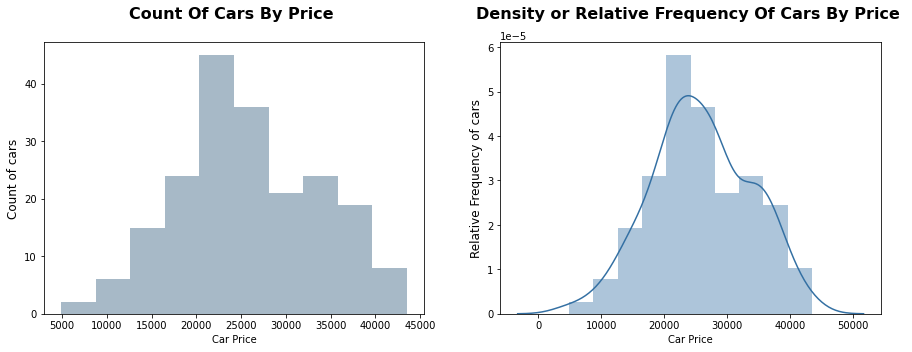

In [ ]:
fig, ax= plt.subplots(1,2,figsize=(15,5))

sns.distplot(df['PRICE'], norm_hist=False, kde=False, ax=ax[0], color='#255075') #'#3470A3', '#79ABC9'
ax[0].set_xlabel('Car Price')
ax[0].set_ylabel('Count of cars',size=12)
ax[0].set_title('Count Of Cars By Price \n',size=16,weight="bold")

sns.distplot(df['PRICE'], kde=True, ax=ax[1], color= '#3470A3')
ax[1].set_xlabel('Car Price')
ax[1].set_ylabel('Relative Frequency of cars',size=12)
ax[1].set_title('Density or Relative Frequency Of Cars By Price \n',size=16,weight="bold")

**Using pairplot to shows the relationship for (n, 2) combination of features in a DataFrame.**

<Figure size 1440x720 with 0 Axes>

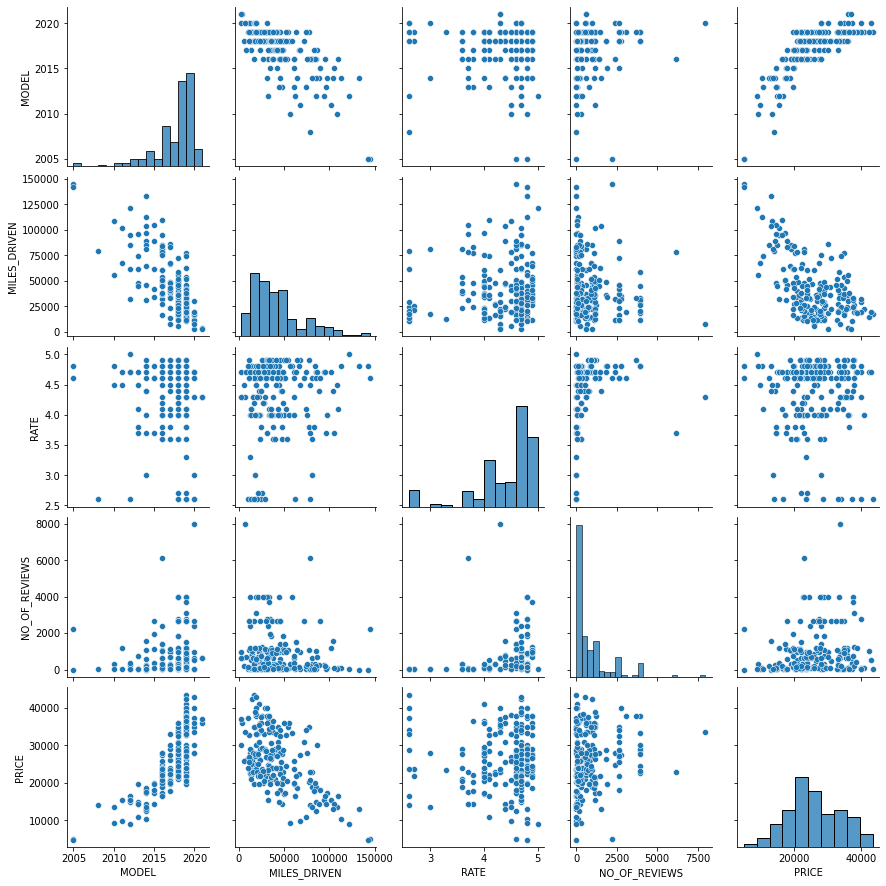

In [ ]:
cars_numeric=df.select_dtypes(include=['float64','int64']) # creating df with numeric features only
plt.figure(figsize=(20, 10)) # size of the figure
sns.pairplot(cars_numeric) 

Before we begin modeling, use the `corr()` function to get a feel for the correlations among the different variables, especially with regard to 'price'.

In [ ]:
df.corr()['PRICE'].sort_values(ascending=False)

PRICE            1.000000
MODEL            0.770530
NO_OF_REVIEWS    0.176931
RATE             0.002358
MILES_DRIVEN    -0.594880
Name: PRICE, dtype: float64

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


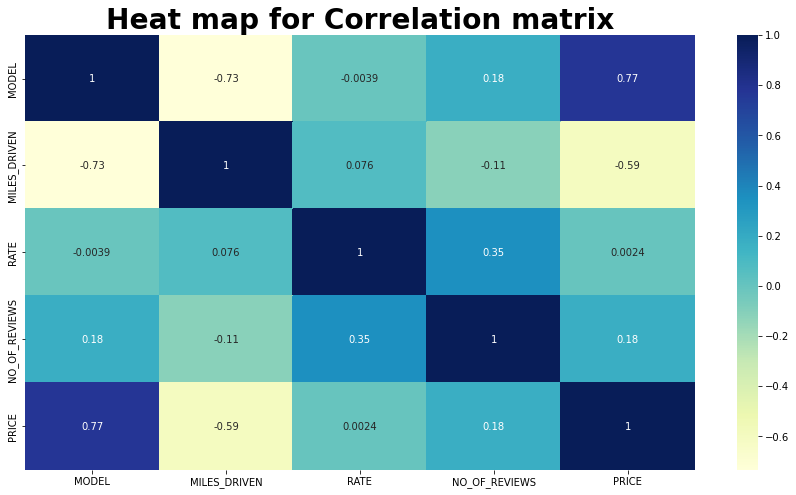

In [ ]:
corr=df.corr()

plt.figure(figsize=(15,8))
plt.title("Heat map for Correlation matrix", fontname="Times New Roman", size=28, fontweight="bold")
sns.heatmap(corr,annot=True,cmap="YlGnBu")

check if there outliers

Box Plot to detect the outliers in each feature

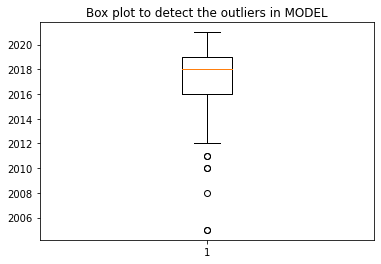

In [ ]:
plt.boxplot(df["MODEL"])
plt.title("Box plot to detect the outliers in MODEL")
plt.show()

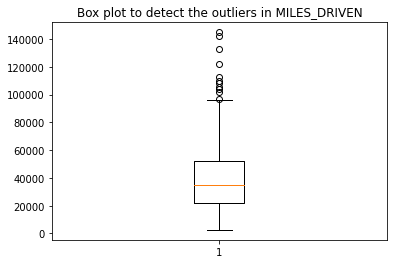

In [ ]:
plt.boxplot(df["MILES_DRIVEN"])
plt.title("Box plot to detect the outliers in MILES_DRIVEN")
plt.show()

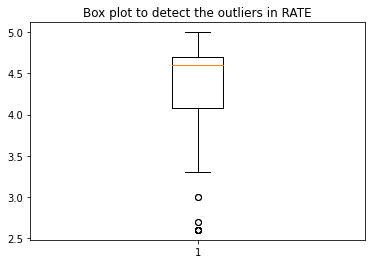

In [ ]:
plt.boxplot(df["RATE"])
plt.title("Box plot to detect the outliers in RATE")
plt.show()

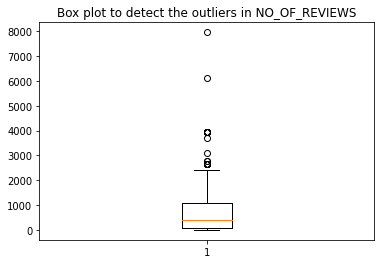

In [ ]:
plt.boxplot(df["NO_OF_REVIEWS"])
plt.title("Box plot to detect the outliers in NO_OF_REVIEWS")
plt.show()

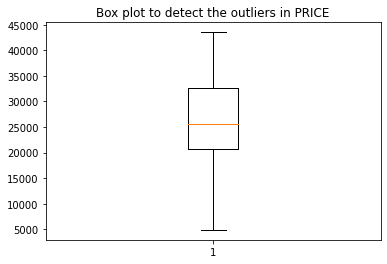

In [ ]:
plt.boxplot(df["PRICE"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

# **Feature engineering**

Creating dummy variables for categorical variables

In [ ]:
dealer_counts = df.DEALER.value_counts() # drop this coulmn because it contains about 96 feature which is a looooooot 
dealer_counts


Schaumburg Honda Automobiles           11
Continental Honda                      11
Honda of Lisle                          9
North City Honda                        9
Honda City Chicago                      8
                                       ..
Star Motor Sales                        1
Napleton Lincoln of Glenview            1
City Volkswagen of Chicago              1
The Autobarn Volvo Cars of Oak Park     1
Jaguar Land Rover Hinsdale              1
Name: DEALER, Length: 95, dtype: int64

In [ ]:
df=df.drop(columns=['DEALER'])

In [ ]:
name_counts = df.CAR_NAME.value_counts() # convert to dummies for features contain 12 variables and more and the others is renamed to others thus will have about 8 features + 6 features and a total of 14 feature 
name_counts

Honda Odyssey EX-L                      22
Honda Accord EX-L                       20
Honda CR-V EX                           17
Honda Civic EX                          12
Honda CR-V LX                           11
Honda Civic LX                          11
Honda CR-V EX-L                          9
Honda Pilot EX-L                         9
Honda Accord Sport                       8
Honda Pilot Touring 7-Passenger          6
Honda Accord LX                          6
Honda CR-V Touring                       6
Honda Pilot EX                           5
Honda HR-V EX                            4
Honda Odyssey EX                         4
Honda HR-V LX                            4
Honda Civic Sport                        4
Honda Ridgeline RTL-E                    3
Honda Pilot Touring                      3
Honda Odyssey SE                         3
Honda Accord Touring                     3
Honda Civic Si Base                      2
Honda Pilot Elite                        2
Honda Civic

In [ ]:
#other_dealer = list(dealer_counts[dealer_counts < 3].index) # "return the indcies for the DEALER counts less than 3"
#df['DEALER'] = df['DEALER'].replace(other_dealer, 'Other') # "replace the DEALER categories having count less than 3"


other_name = list(name_counts[name_counts < 12].index) # "return the indcies for the DEALER counts less than 3"
df['CAR_NAME'] = df['CAR_NAME'].replace(other_name, 'Other')


df= pd.get_dummies(df, drop_first=True)

In [ ]:
df

,MODEL,MILES_DRIVEN,RATE,NO_OF_REVIEWS,PRICE,CAR_NAME_Honda CR-V EX,CAR_NAME_Honda Civic EX,CAR_NAME_Honda Odyssey EX-L,CAR_NAME_Other
0,2016,46994.0,4.0,67,22665.0,1,0,0,0
1,2016,49473.0,4.0,67,17137.0,0,0,0,1
2,2018,19944.0,4.0,67,28000.0,1,0,0,0
3,2018,37295.0,4.3,635,33599.0,0,0,1,0
4,2021,3697.0,4.3,635,35999.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
195,2014,31555.0,3.7,43,17500.0,0,0,0,0
196,2019,38039.0,3.8,20,36439.0,0,0,0,1
197,2017,82815.0,3.8,20,17900.0,0,0,0,1
198,2019,28090.0,4.7,126,20557.0,0,0,0,1


In [ ]:
df.columns

Index(['MODEL', 'MILES_DRIVEN', 'RATE', 'NO_OF_REVIEWS', 'PRICE',
       'CAR_NAME_Honda CR-V EX', 'CAR_NAME_Honda Civic EX',
       'CAR_NAME_Honda Odyssey EX-L', 'CAR_NAME_Other'],
      dtype='object')

Split data into train and test

In [ ]:
X=df.drop(columns=['PRICE'])

In [ ]:
y=df['PRICE']
df_train,df_test=train_test_split(df,train_size=0.75,random_state=42)

In [ ]:
df_train2, df_val = train_test_split(df_train, test_size=0.25, random_state=3)

**Scaling**

scaling the features makes interpretation of regression coefficients easier

In [ ]:
#columns_scale=df.columns
#df_scaled=pd.DataFrame(scale(df))
#df_scaled.columns=columns_scale
#df_scaled.columns

In [ ]:
scaler = StandardScaler()
df_train2[df.columns]=scaler.fit_transform(df_train2[df.columns])
df_val[df.columns]=scaler.transform(df_val[df.columns])
df_test[df.columns]=scaler.transform(df_test[df.columns])

X_train=df_train2.drop('PRICE',axis=1)
y_train=df_train2['PRICE']
X_val=df_val.drop('PRICE',axis=1)
y_val=df_val['PRICE']
X_test=df_test.drop('PRICE',axis=1)
y_test=df_test['PRICE']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
#df_scaled.describe() 
#After scaling the features we noticed the std =1

Show the length of the (X_train, X_test, y_train and y_test) to verify that the process of splitting the data was done correctly.

In [ ]:
print("Length of the X_train = ",len(X_train))
print("Length of the y_train = ",len(y_train))
print("Length of the X_test = ",len(X_test))
print("Length of the y_test = ",len(y_test))
print("Length of the y_val = ",len(y_val))
print("Length of the y_val = ",len(y_val))

Length of the X_train =  112
Length of the y_train =  112
Length of the X_test =  50
Length of the y_test =  50
Length of the y_val =  38
Length of the y_val =  38


# **Model Building**

Model with all features

In [ ]:
lm=LinearRegression()
lm1= lm.fit(X_train,y_train)
y_pred_val=lm1.predict(X_val)
y_pred_train=lm1.predict(X_train)
y_pred_test=lm1.predict(X_test)
print("Score of training set = ",lm1.score(X_train,y_train))

Score of training set =  0.7070045132621869


In [ ]:
print("Score of validation set = ",lm1.score(X_val,y_val))

Score of validation set =  0.6495481371602382


In [ ]:
print("Score of test set = ",lm1.score(X_test,y_test))

Score of test set =  0.604700006712553


In [ ]:
y_pred_train.shape 

(112,)

In [ ]:
y_train.shape

(112,)

In [ ]:
X_train.shape 

(112, 8)

In [ ]:
X_val.shape

(38, 8)

In [ ]:
y_val.shape

(38,)

Train data 

In [ ]:
def SSE(actuals, preds):
    return np.sum((actuals - preds)**2)

SSE(y_pred_train,y_train)

32.81549451463507

In [ ]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

RMSE(y_pred_train,y_train)

0.5412905751422364

In [ ]:
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

MAE(y_pred_train,y_train)

0.41610838177730686

In [ ]:
def SST(y):
    return np.sum((y - np.mean(y))**2)

In [ ]:
def R2(actuals, preds):
    return 1 - SSE(actuals, preds) / SST(actuals)

R2(y_pred_train,y_train)

0.5855818721921529

validation data 

In [ ]:
def SSE(actuals, preds):
    return np.sum((actuals - preds)**2)

SSE(y_pred_val,y_val)

13.513115416501897

In [ ]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

RMSE(y_pred_val,y_val)

0.5963290202851614

In [ ]:
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

MAE(y_pred_val,y_val)

0.46363964770766725

In [ ]:
def SST(y):
    return np.sum((y - np.mean(y))**2)
def R2(actuals, preds):
    return 1 - SSE(actuals, preds) / SST(actuals)

R2(y_pred_val,y_val)

0.43340856220556445

In [ ]:
results = sm.OLS(y_pred_train, y_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                              267.8
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                    2.31e-31
Time:                        06:09:46   Log-Likelihood:                         -70.759
No. Observations:                 112   AIC:                                      143.5
Df Residuals:                     111   BIC:                                      146.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PRICE          0.7070      0.043     16.366      0.000       0.621       0.793
==============================================================================
Omnibus:                        4.655   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                4.045
Skew:                          -0.432   Prob(JB):                        0.132
Kurtosis:                       3.348   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
results = sm.OLS(y_pred_val, y_val).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.650
Model:                            OLS   Adj. R-squared (uncentered):              0.641
Method:                 Least Squares   F-statistic:                              68.75
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                    5.83e-10
Time:                        06:09:46   Log-Likelihood:                         -25.117
No. Observations:                  38   AIC:                                      52.23
Df Residuals:                      37   BIC:                                      53.87
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PRICE          0.6340      0.076      8.291      0.000       0.479       0.789
==============================================================================
Omnibus:                        2.220   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                1.742
Skew:                          -0.361   Prob(JB):                        0.419
Kurtosis:                       2.238   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is overfitting, so we doing the Feature selection using RFE 

# Linear Regression Assumptions Validation

**Assumption 1: regression is linear in parameters and correctly specified**

In [ ]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x) # "regression prediction"

    plt.subplot(1, 3, 1)
    plt.scatter(x,y) # "scatter"
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res) # "scatter supposed to have no pattern"
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt) # "normal qq plot"
    plt.title("Normal Q-Q plot")

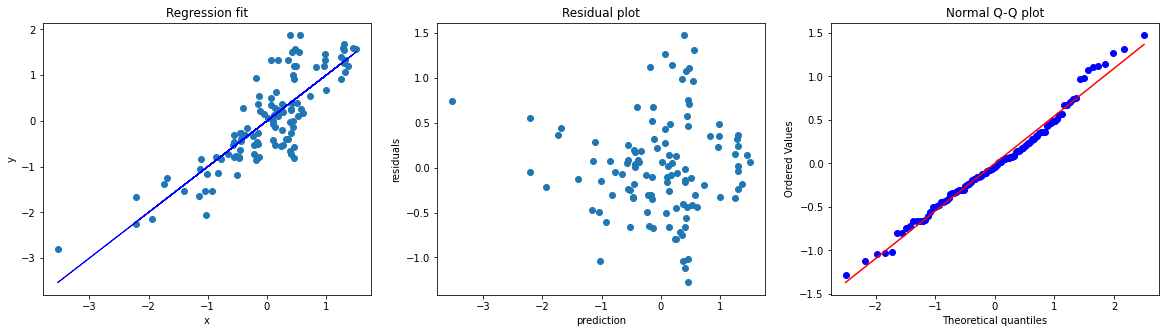

In [ ]:
diagnostic_plot(y_pred_train.reshape(112,1), y_train)

**Assumption 2: residuals ( ${e_i} = Y_i-\hat{Y}_i$ ) should be normally distributed with zero mean**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


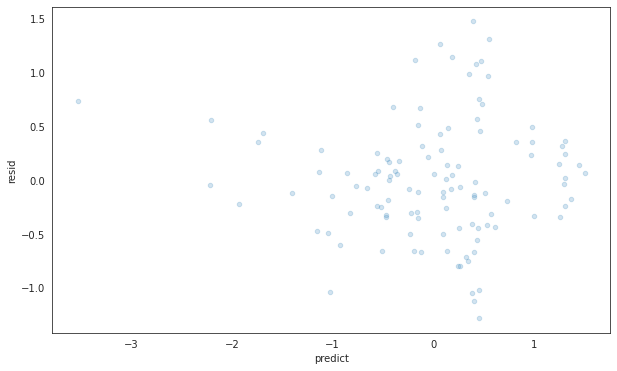

In [ ]:
df_train2['predict']=y_pred_train
df_train2['resid']=y_train-df_train2.predict  # "residuals"
with sns.axes_style('white'):
    plot=df_train2.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

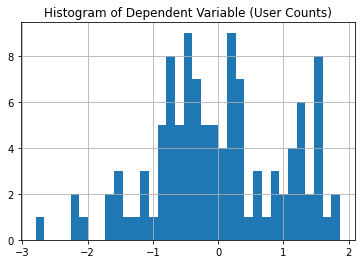

In [ ]:
y_train.hist(bins=35)
plt.title('Histogram of Dependent Variable (User Counts)');

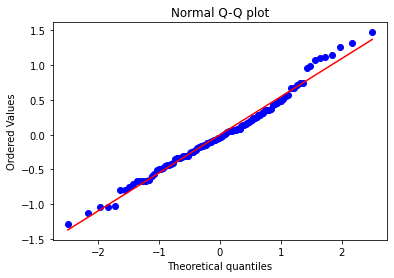

In [ ]:
stats.probplot(df_train2['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

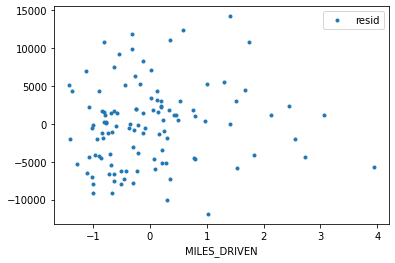

In [ ]:
ts = df_train2[['MILES_DRIVEN','resid']].set_index('MILES_DRIVEN')
ts.plot(style=".");

Assumption 3: error terms must have constant variance





In [ ]:
model = sm.OLS(y,X) # "from stats package"
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              574.4
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                   1.14e-129
Time:                        06:09:50   Log-Likelihood:                         -2003.3
No. Observations:                 200   AIC:                                      4023.
Df Residuals:                     192   BIC:                                      4049.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
MODEL                          13.7354      1.678      8.188      0.000      10.427      17.044
MILES_DRIVEN                   -0.1513      0.014    -10.645      0.000      -0.179      -0.123
RATE                          105.9723    741.462      0.143      0.887   -1356.484    1568.429
NO_OF_REVIEWS                   0.3361      0.353      0.952      0.343      -0.361       1.033
CAR_NAME_Honda CR-V EX       2631.2474   1832.346      1.436      0.153    -982.865    6245.360
CAR_NAME_Honda Civic EX     -1839.0398   2022.211     -0.909      0.364   -5827.642    2149.562
CAR_NAME_Honda Odyssey EX-L  1.145e+04   1727.213      6.627      0.000    8038.683    1.49e+04
CAR_NAME_Other               3805.4891   1337.075      2.846      0.005    1168.248    6442.730
==============================================================================
Omnibus:                        7.226   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.142
Skew:                           0.459   Prob(JB):                       0.0281
Kurtosis:                       3.112   Cond. No.                     3.62e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


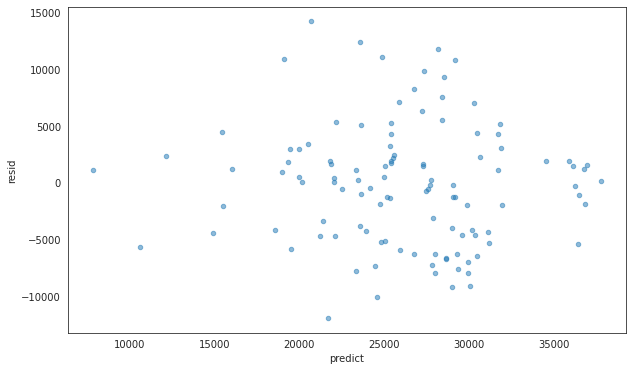

In [ ]:
# create residual plot
df_train2['predict']=fit.predict(X) # "we added the predication to the data frame"
df_train2['resid']= y-df_train2.predict # "we added the residuals to the data frame"
with sns.axes_style('white'):
    plot = df_train2.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

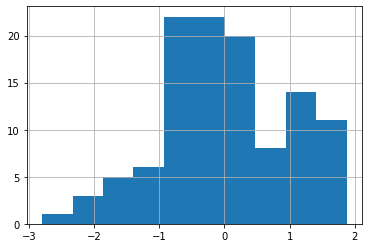

In [ ]:
df_train2.PRICE.hist();

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


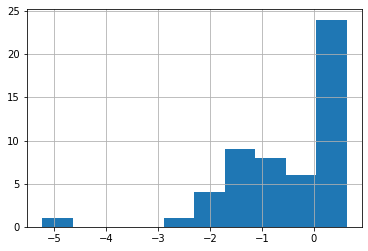

In [ ]:
np.log(df_train2.PRICE).hist();

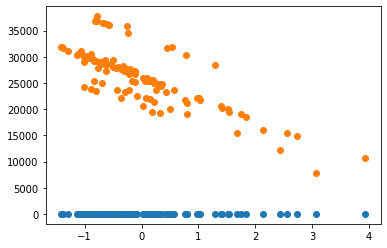

In [ ]:
plt.scatter(df_train2.MILES_DRIVEN,y_train)
plt.scatter(df_train2.MILES_DRIVEN,df_train2.predict);

In [ ]:
#lamb=stats.boxcox_normmax(df_train2.PRICE, brack=(-1.9, 1.9)) # "Compute optimal Box-Cox transform parameter for input data, brack for intilization"
#print("Lambda:", lamb)
#y_t=(np.power(df_train2.PRICE,-0.2282)-1)/-0.2282 # "the value of lambda is choosen from the box cox normality plot"

#plt.hist(y_t);

**Assumption 4: errors are uncorrelated across observations**



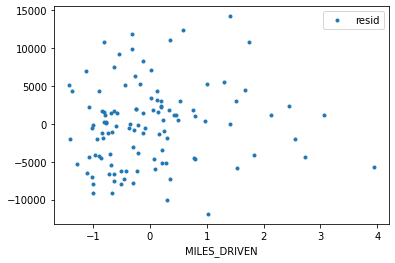

In [ ]:
ts = df_train2[['MILES_DRIVEN','resid']].set_index('MILES_DRIVEN')
ts.plot(style=".");

Assumption 5: no independent variable is a perfect linear function of any other independent variable (no perfect multi-collinearity)

**Feature selection using RFE using the STATSMODELS**




In [ ]:
#features_list = list(range(4, 10)) #checking for optimal number of features between 4 to 30
#train_adjusted_r2 = []
#train_r2 = []
#test_r2 = []
#train_RMSE=[]
#test_RMSE=[]

#for n_features in range(4, 10):

    # RFE with n features
 #   lm = LinearRegression()
 #   rfe_n = RFE(estimator=lm, n_features_to_select=n_features) # specifying number of features

  #  rfe_n.fit(X_train, y_train)  # fit with n features

    # selecting features selected by rfe_n
   # col_n = X_train.columns[rfe_n.support_] #rfe_n.support_: returns an array with boolean values to indicate whether 
    #an attribute was selected using RFE

Training & test data for n selected columns

In [ ]:
 #X_train_rfe_n = X_train[col_n]
 #X_test_rfe_n = X_test[col_n]

 # add a constant to the model
#X_train_rfe_n = sm.add_constant(X_train_rfe_n)
#X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

Fitting the model with n featues

In [ ]:
#lm_n = sm.OLS(y_train, X_train_rfe_n).fit()

Making predictions

In [ ]:
#y_pred_test = lm_n.predict(X_test_rfe_n)
#y_pred_train = lm_n.predict(X_train_rfe_n)

**Calculating the evaluation metrics**

R-square

In [ ]:
#train_adjusted_r2.append(lm_n.rsquared_adj)
#train_r2.append(lm_n.rsquared)
#test_r2.append(r2_score(y_test, y_pred_test))

RMSE/stan. error

In [ ]:
#error_test=y_pred_test-y_test
#error_train=y_pred_train-y_train
    
#test_RMSE.append(((error_test**2).mean())**0.5)
#train_RMSE.append(((error_train**2).mean())**0.5)

Plotting r2 and RMSE against n_features

## **Regularized Linear Regression (LASSO)**

**Lasso with different lambdas**

Apply the Lasso regression on the training set

In [ ]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

prepare data for enumerate

In [ ]:
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
validate_r_squared = np.zeros(l_num)

In [ ]:
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    validate_r_squared[ind] = reg.score(X_val, y_val)

Plot all values in the train and test set for both data sets 
R
2
-values as a function of λ. 

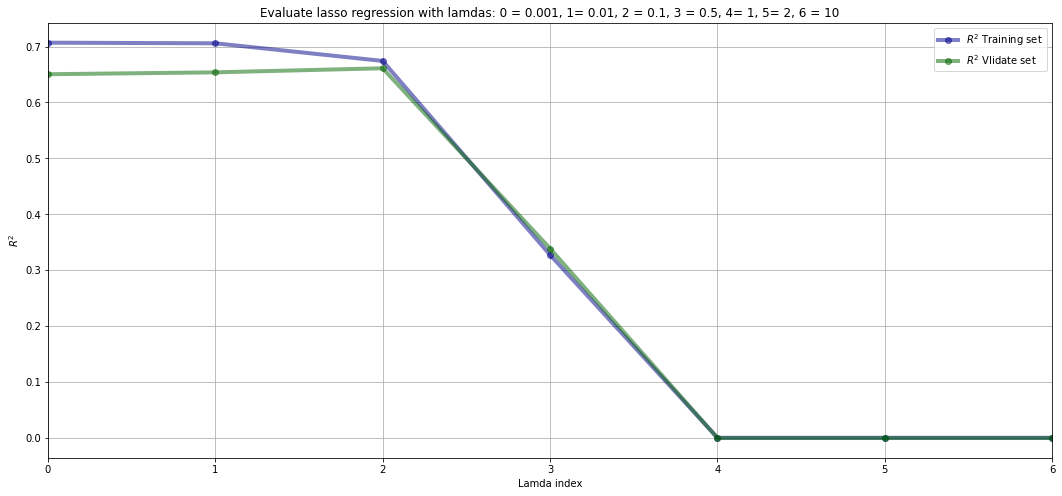

In [ ]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue",alpha=0.5,  linewidth=4)
plt.plot(validate_r_squared, 'bo-', label=r'$R^2$ Vlidate set', color="darkgreen",alpha=0.5, linewidth=4)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

**Identify best lambda and coefficients**

save the test set into DataFrame

In [ ]:
df_lam = pd.DataFrame(validate_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)

Indentify the lambda where the 
R
2
 has it’s maximum value

In [ ]:
df_lam.loc[df_lam['R_squared'].idxmax()] # returns the index of the row.

R_squared    66.121861
lambda        0.100000
Name: 2, dtype: float64

Fit a Lasso model using the training set and obtain the corresponding regression coefficients

In [ ]:
reg_best = Lasso(alpha = 0.01)
reg_best.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

R^2 for the validation set

In [ ]:
print(" R^2 for the Validation:", r2_score(y_val,  reg_best.predict(X_val)))

 R^2 for the Validation: 0.6539277294442638


Cross Validation

Evaluate the Lasso regression for different regularization parameters (lamdas) using 5 fold cross validation 

In [ ]:
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [ ]:
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

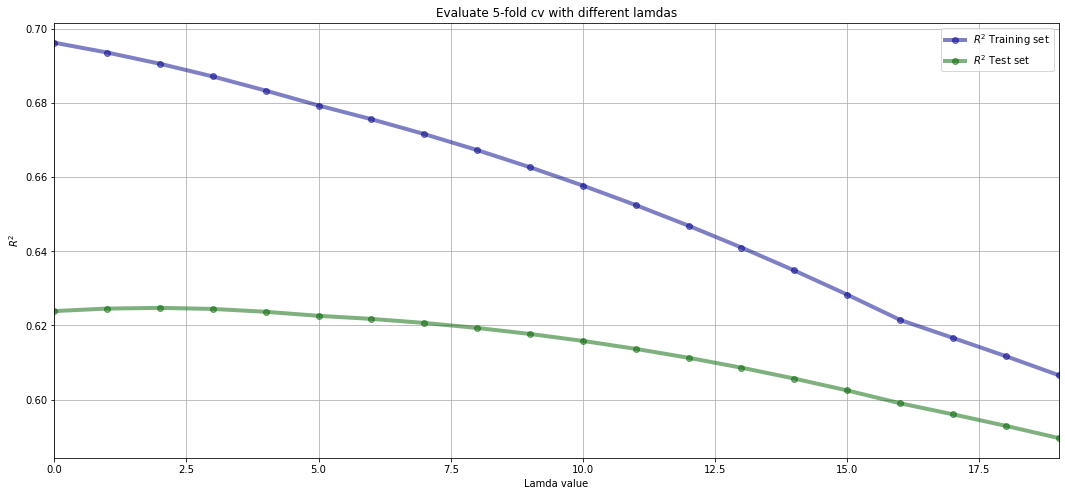

In [ ]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.5, linewidth=4)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkgreen", alpha=0.5, linewidth=4)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

Best Model

In [ ]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    62.474675
lambda        0.065789
Name: 2, dtype: float64

In [ ]:
reg_best = Lasso(alpha = 0.05)
reg_best.fit(X_train, y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
print(" R^2=", r2_score(y_test,  reg_best.predict(X_test)))

 R^2= 0.6238808549313377


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
# Create model
model_l = Lasso(alpha=0.002)

# Fit model
model_l.fit(X_train, y_train)
predictions = model_l.predict(X_train)
print("Train:", r2_score(y_train, predictions))

# Evaluate
predictions = model_l.predict(X_val)
print("Validation:", r2_score(y_val, predictions))

Train: 0.7069422647448813
Validation: 0.6515371074177834


In [ ]:
from sklearn.linear_model import LassoCV
# Create 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=13)

# Create model
model_lcv = LassoCV(cv=kfold)

# Fit model
model_lcv.fit(X_train, y_train)
predictions = model_lcv.predict(X_train)
print("Train:", r2_score(y_train, predictions))

# Evaluate
predictions = model_lcv.predict(X_val)
print("Validation:", r2_score(y_val, predictions))

print("Alpha:", model_lcv.alpha_)

Train: 0.7030603218914622
Validation: 0.6596382435117242
Alpha: 0.023203678443060843
